In [142]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [143]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [144]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [145]:
from models.CRNN import CRNN_model

# 1. Data

In [146]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

strategy.ret.loc['2005-02-16'] = strategy.ret.loc['2005-02-17']

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-10-31 09:05:31,356 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:05:31,356 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:05:31,356 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:05:31,356 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:05:31,356 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:05:31,359 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:05:31,359 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:05:31,359 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:05:31,359 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:05:31,359 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:05:31,361 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:05:31,361 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:05:31,361 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:05:31,361 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:05:31,361 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


# 2. Explore

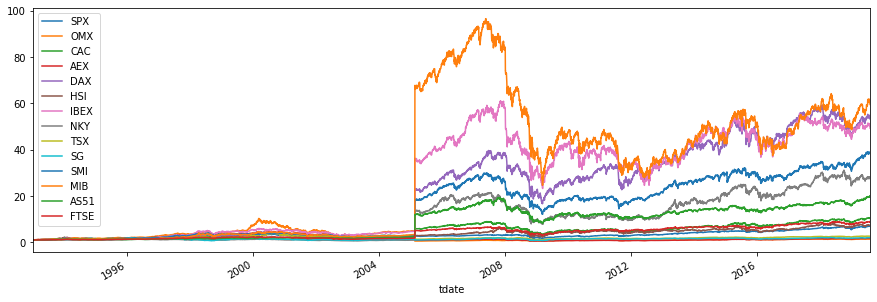

In [147]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

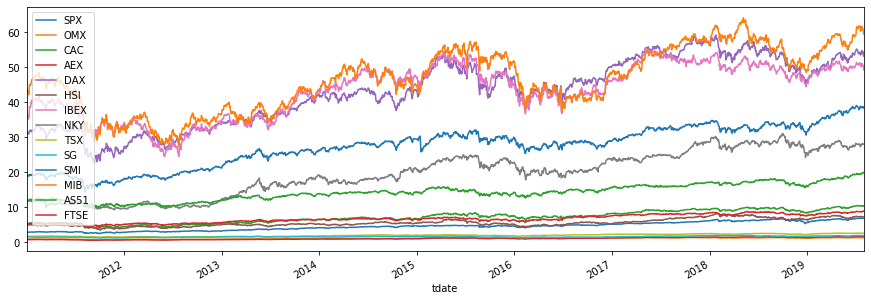

In [148]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index.loc['2011':][column].plot()
plt.legend()

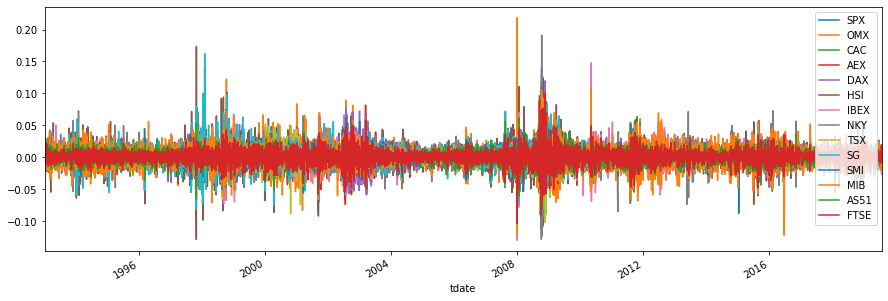

In [149]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [150]:
indiv_momentum_lst = [1, 2, 3, 4, 5, 10, 21]

## 1. X

### moving average 와 주가 차이

In [151]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [152]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [153]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [154]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EPM_PAST.png">

<img src="./result/EPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [155]:
one_week = 5
one_month = 20

In [156]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [157]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [158]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [159]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [160]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [161]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [162]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692728	valid_1's binary_logloss: 0.692728
[20]	training's binary_logloss: 0.692372	valid_1's binary_logloss: 0.692372
[30]	training's binary_logloss: 0.692062	valid_1's binary_logloss: 0.692062
[40]	training's binary_logloss: 0.69178	valid_1's binary_logloss: 0.69178
[50]	training's binary_logloss: 0.691526	valid_1's binary_logloss: 0.691526
[60]	training's binary_logloss: 0.691298	valid_1's binary_logloss: 0.691298
[70]	training's binary_logloss: 0.691082	valid_1's binary_logloss: 0.691082
[80]	training's binary_logloss: 0.690891	valid_1's binary_logloss: 0.690891
[90]	training's binary_logloss: 0.690713	valid_1's binary_logloss: 0.690713
[100]	training's binary_logloss: 0.690545	valid_1's binary_logloss: 0.690545
[110]	training's binary_logloss: 0.690396	valid_1's binary_logloss: 0.690396
[120]	training's binary_logloss: 0.690253	valid_1's binary_logloss: 0.690253
[130]	training's binary_l

In [163]:
test_pred = model.predict(df_test_x.values)

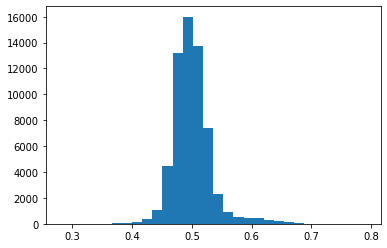

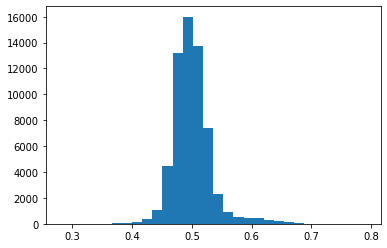

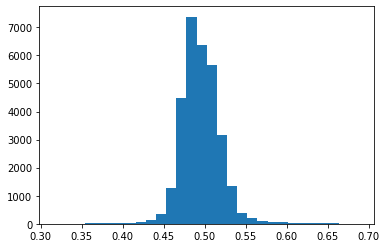

In [164]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [165]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [166]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [167]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [168]:
df_index_sub = df_index.loc['1994':]

In [169]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [170]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [171]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-31 09:05:37,873 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:05:37,873 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:05:37,873 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:05:37,873 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:05:37,873 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [172]:
tester = Tester(strategy)

In [173]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [174]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-31 09:05:38,290 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:05:38,290 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:05:38,290 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:05:38,290 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:05:38,290 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:05:38,292 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:05:38,292 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:05:38,292 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:05:38,292 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:05:38,292 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:05:38,294 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:05:38,294 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:05:38,294 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:05:38,294 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:05:38,294 - EPM - I

### TRAIN

2019-10-31 09:06:04,890 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:04,890 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:04,890 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:04,890 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:04,890 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:04,893 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:04,893 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:04,893 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:04,893 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:04,893 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:04,903 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:06:04,903 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:06:04,903 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:06:04,903 - EPM - INFO - [STEP 6 - 2] BACKT

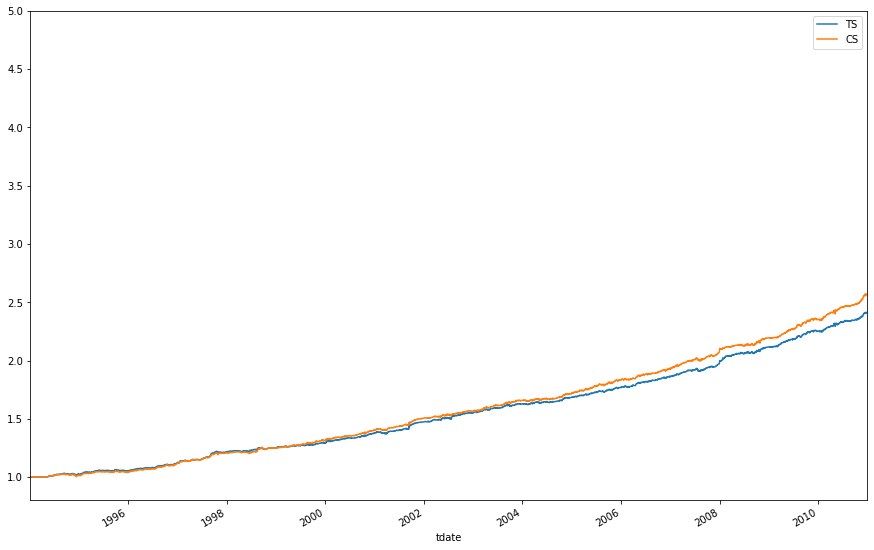

In [175]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-31 09:06:05,074 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:05,074 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:05,074 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:05,074 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:05,074 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:06:05,076 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:05,076 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:05,076 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:05,076 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:05,076 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:06:05,084 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:06:05,084 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:06:05,084 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:06:05,084 - EPM - INFO - [STEP 6 - 2] BACKT

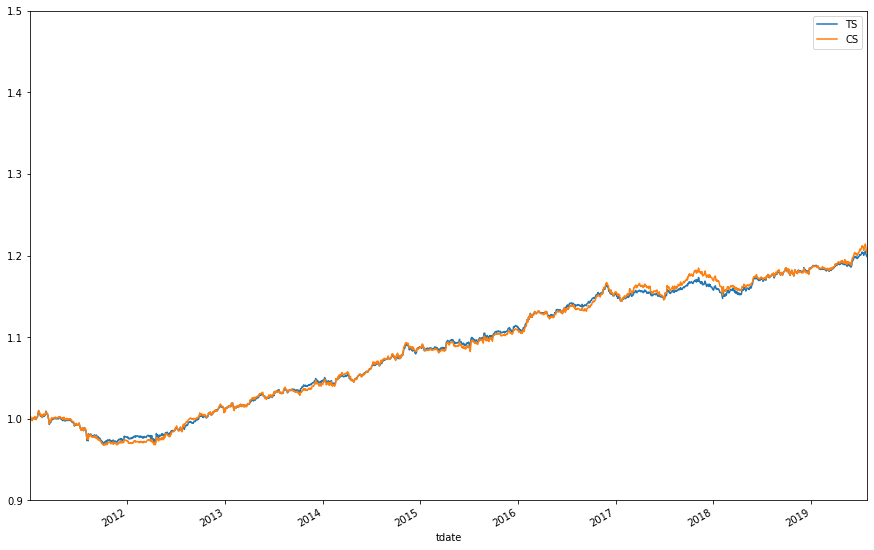

In [176]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [36]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [37]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [38]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [39]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [40]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [41]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [ ]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.68621	valid_1's binary_logloss: 0.697362
[20]	training's binary_logloss: 0.685542	valid_1's binary_logloss: 0.696915
[30]	training's binary_logloss: 0.684965	valid_1's binary_logloss: 0.696549
[40]	training's binary_logloss: 0.684453	valid_1's binary_logloss: 0.69624
[50]	training's binary_logloss: 0.683999	valid_1's binary_logloss: 0.695974
[60]	training's binary_logloss: 0.683579	valid_1's binary_logloss: 0.695736
[70]	training's binary_logloss: 0.683192	valid_1's binary_logloss: 0.695514
[80]	training's binary_logloss: 0.682835	valid_1's binary_logloss: 0.695327
[90]	training's binary_logloss: 0.682516	valid_1's binary_logloss: 0.695143
[100]	training's binary_logloss: 0.682209	valid_1's binary_logloss: 0.695003
[110]	training's binary_logloss: 0.681942	valid_1's binary_logloss: 0.69485
[120]	training's binary_logloss: 0.681664	valid_1's binary_logloss: 0.694699
[130]	training's binary_lo

In [ ]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

In [ ]:
plt.hist(pred2, bins=30)

In [ ]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [ ]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'

strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

strategy2.ret.loc['2005-02-16'] = strategy2.ret.loc['2005-02-17']

In [ ]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

### TRAIN

In [ ]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

In [ ]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 3. Case1을 Rolling으로 실행

In [ ]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [ ]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [ ]:
models = []
train_preds = []
test_preds = []

In [ ]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

In [ ]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

In [ ]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [ ]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [ ]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'

strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

strategy3.ret.loc['2005-02-16'] = strategy3.ret.loc['2005-02-17']

In [ ]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

In [ ]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 4. CASE 2를 ROLLING으로 실행

In [ ]:
models = []
train_preds = []
test_preds = []

In [ ]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

In [ ]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [ ]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [ ]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'

strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

strategy4.ret.loc['2005-02-16'] = strategy4.ret.loc['2005-02-17']

In [ ]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

In [ ]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))